# Word Embeddings : le modèle Word2Vec

## Imports

In [1]:
# --- IMPORTS & chargement des données du clustering ---
import pickle
import pandas as pd
import numpy as np
import re
from tqdm import tqdm

import gensim
from gensim.models import Word2Vec

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# --- CHARGEMENT DES RESULTATS DU CLUSTERING ---
with open("clustering_results.pkl", "rb") as f:
    data = pickle.load(f)

clean_texts = data["clean_texts"]
clean_files = data["clean_files"]
clusters = data["clusters"]
N_CLUSTERS = data["N_CLUSTERS"]

print(f"Nombre de documents : {len(clean_texts)}")
print(f"Clusters : {N_CLUSTERS}")


Nombre de documents : 320
Clusters : 6


## Prettraitement Word2Vec - tokenisation légère

In [3]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

def tokenize(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(r"\s+", " ", text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if len(t) > 2]  # éviter les mots trop courts
    return tokens

tokenized_texts = [tokenize(t) for t in clean_texts]

print(tokenized_texts[0][:20])


[nltk_data] Downloading package punkt to /Users/ilaria/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['samedi', 'janvier', '1951', 'som', 'conseil', 'guerre', 'bruxelles', 'procès', 'von', 'falkenhausen', 'audience', 'vendredi', 'rolin', 'poursuivant', 'réplique', 'traite', 'question', 'juive', 'souligne', 'les']


## Entraînement Word2Vec GLOBAL (sur tout le corpus)

In [4]:
model_global = Word2Vec(
    sentences=tokenized_texts,
    vector_size=100,
    window=5,
    min_count=3,
    workers=4,
    sg=1  # skip-gram = meilleur pour les analyses sémantiques
)

model_global.save("w2v_global.model")
print("Modèle Word2Vec global entraîné.")


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Modèle Word2Vec global entraîné.


In [5]:
# entraînement de modèles Word2Vec par cluster
texts_by_cluster = {c: [] for c in range(N_CLUSTERS)}

for text, cl in zip(tokenized_texts, clusters):
    texts_by_cluster[cl].append(text)

models_cluster = {}

for c in range(N_CLUSTERS):
    print(f"Entraînement Word2Vec pour cluster {c}...")
    models_cluster[c] = Word2Vec(
        sentences=texts_by_cluster[c],
        vector_size=100,
        window=5,
        min_count=2,
        workers=4,
        sg=1
    )
    models_cluster[c].save(f"w2v_cluster_{c}.model")

print("Tous les modèles par cluster sont entraînés.")


Entraînement Word2Vec pour cluster 0...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Entraînement Word2Vec pour cluster 1...
Entraînement Word2Vec pour cluster 2...
Entraînement Word2Vec pour cluster 3...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Entraînement Word2Vec pour cluster 4...
Entraînement Word2Vec pour cluster 5...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Tous les modèles par cluster sont entraînés.


In [6]:
# explorer les voisins sémantiques (par cluster )
def show_neighbors(word, model):
    if word not in model.wv:
        print(f"'{word}' absent du vocabulaire.")
        return
    print(f"--- Voisins de '{word}' ---")
    for w, score in model.wv.most_similar(word, topn=10):
        print(f"{w:20s}  {score:.3f}")



In [ ]:
# Exemple
for c in range(N_CLUSTERS):
    print("\n============== CLUSTER", c, "==============")
    show_neighbors("sorcière", models_cluster[c])



============== CLUSTER 0 ==============
--- Voisins de 'sorcière' ---
vieille               0.972
tête                  0.971
belle                 0.968
épouse                0.964
cachée                0.962
fleur                 0.961
osborne               0.959
mari                  0.959
dame                  0.957
fils                  0.957

============== CLUSTER 1 ==============
--- Voisins de 'sorcière' ---
aimée                 0.985
sports                0.948
colorix               0.943
animaux               0.939
police                0.934
heures                0.931
cirque                0.927
métiers               0.926
parle                 0.925
jours                 0.925

============== CLUSTER 2 ==============
--- Voisins de 'sorcière' ---
blanche               0.987
fille                 0.983
stockel               0.976
sch                   0.975
monty                 0.974
nova                  0.972
noir                  0.972
pax                   0.972
eli

In [8]:
show_neighbors("femme", models_cluster[c])
show_neighbors("procès", models_cluster[c])
show_neighbors("féminisme", models_cluster[c])


--- Voisins de 'femme' ---
sorcière              0.949
fille                 0.945
petite                0.936
jeune                 0.933
bonne                 0.933
jolie                 0.932
belle                 0.930
personnage            0.920
homme                 0.920
mère                  0.920
--- Voisins de 'procès' ---
discours              0.996
composée              0.996
ventre                0.996
revit                 0.996
alerte                0.996
collaboration         0.996
étend                 0.996
séduite               0.996
pensées               0.996
consécration          0.996
'féminisme' absent du vocabulaire.


# Compârer la distance entre deux mots selon les clusters

In [9]:
def compare_similarity(word1, word2):
    print(f"\n### Similarité: {word1} ↔ {word2}")
    for c in range(N_CLUSTERS):
        model = models_cluster[c]
        if word1 in model.wv and word2 in model.wv:
            sim = model.wv.similarity(word1, word2)
            print(f"Cluster {c}: {sim:.3f}")
        else:
            print(f"Cluster {c}: absent")

compare_similarity("sorcière", "femme")
compare_similarity("sorcière", "procès")
compare_similarity("femme", "homme")



### Similarité: sorcière ↔ femme
Cluster 0: 0.950
Cluster 1: 0.747
Cluster 2: 0.876
Cluster 3: 0.942
Cluster 4: 0.817
Cluster 5: 0.949

### Similarité: sorcière ↔ procès
Cluster 0: 0.800
Cluster 1: 0.854
Cluster 2: 0.895
Cluster 3: 0.930
Cluster 4: 0.940
Cluster 5: 0.874

### Similarité: femme ↔ homme
Cluster 0: 0.887
Cluster 1: 0.613
Cluster 2: 0.865
Cluster 3: 0.889
Cluster 4: 0.610
Cluster 5: 0.920


## Visualisation PCA des espaces sémantiques (par cmuster)

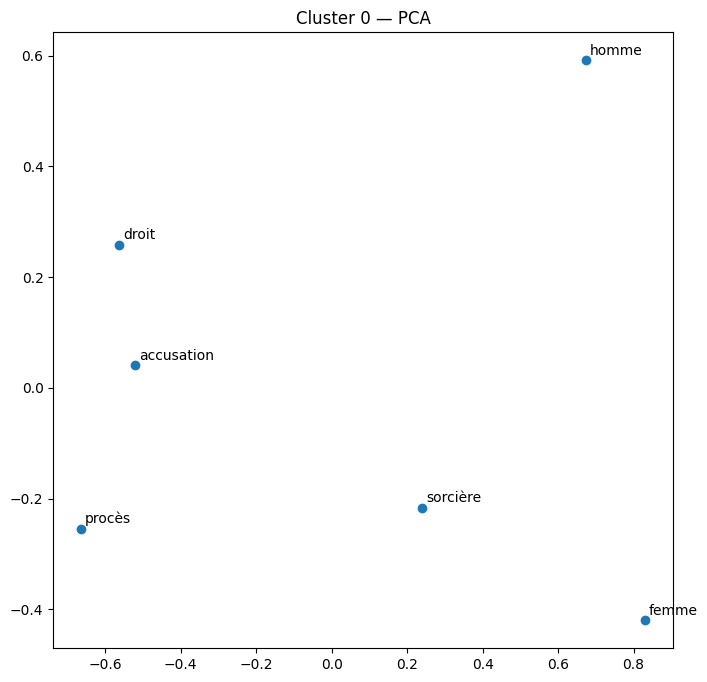

In [10]:
def plot_words(model, words, title="PCA Embeddings"):
    vecs = []
    labels = []
    
    for w in words:
        if w in model.wv:
            vecs.append(model.wv[w])
            labels.append(w)
    
    if len(vecs) < 2:
        print("Pas assez de mots dans le modèle.")
        return
    
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(vecs)

    plt.figure(figsize=(8,8))
    plt.scatter(reduced[:,0], reduced[:,1])

    for i, label in enumerate(labels):
        plt.text(reduced[i,0]+0.01, reduced[i,1]+0.01, label)

    plt.title(title)
    plt.show()

words_interest = ["sorcière","femme","féminisme","procès","homme","droit","accusation"]

plot_words(models_cluster[0], words_interest, "Cluster 0 — PCA")


## Réseaux sémantiques à partir des embeddings

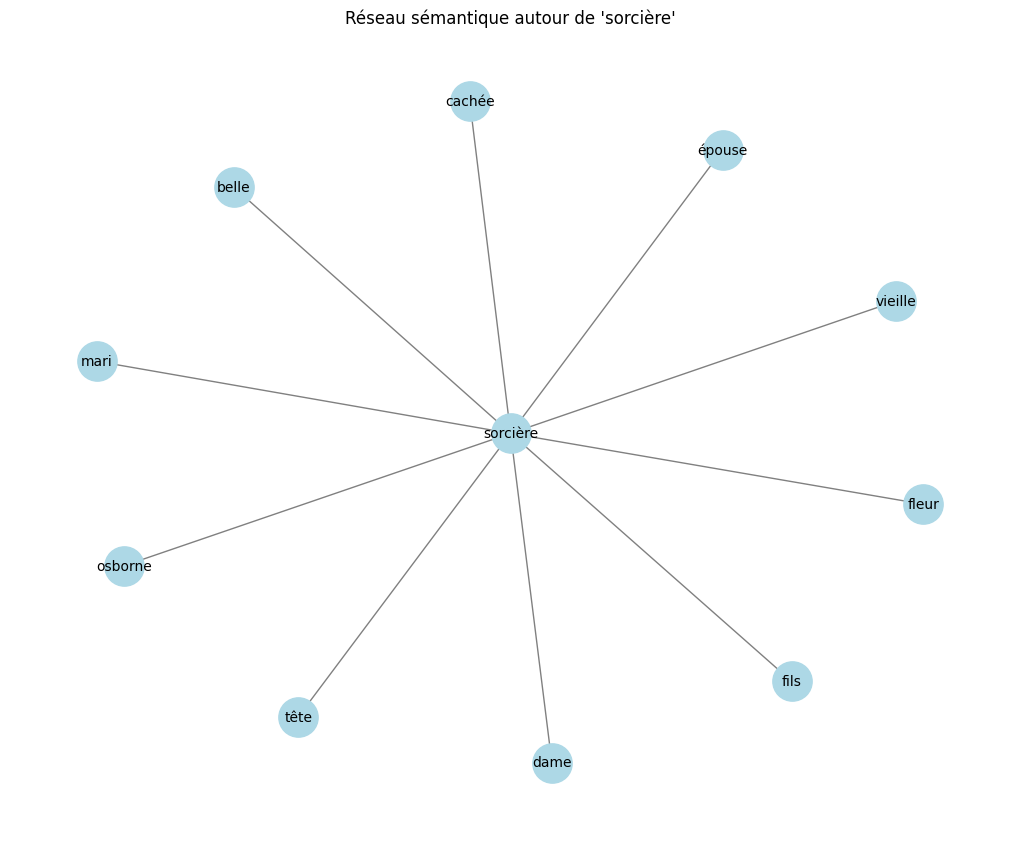

In [11]:
import networkx as nx

def graph_neighbors(model, word, topn=10):
    if word not in model.wv:
        print(f"{word} absent.")
        return
    
    neighbors = model.wv.most_similar(word, topn=topn)
    
    G = nx.Graph()
    G.add_node(word)

    for w, score in neighbors:
        G.add_node(w)
        G.add_edge(word, w, weight=score)
    
    plt.figure(figsize=(10,8))
    pos = nx.spring_layout(G, k=0.5, seed=42)
    
    nx.draw(
        G, pos,
        with_labels=True,
        node_size=800,
        node_color="lightblue",
        font_size=10,
        edge_color="gray"
    )
    plt.title(f"Réseau sémantique autour de '{word}'")
    plt.show()

graph_neighbors(models_cluster[0], "sorcière")


## Analyse automatique ds différence inter-cluster


### Variations sémantiques du mot: sorcière


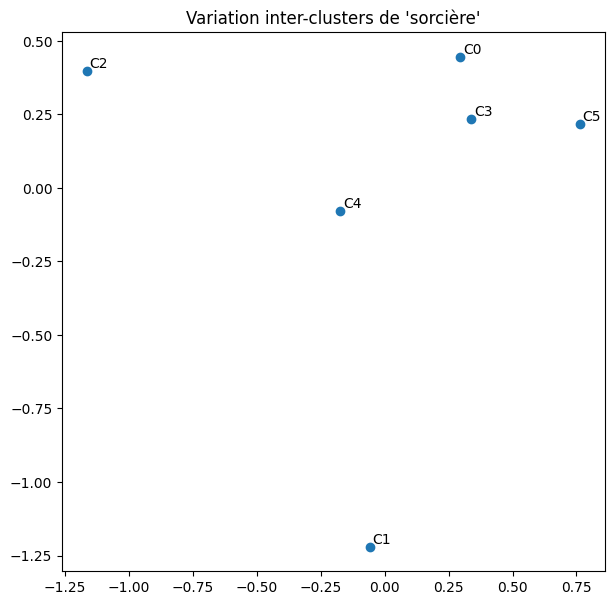

In [12]:
def differential_neighbors(word):
    print(f"\n### Variations sémantiques du mot: {word}")
    
    cluster_vectors = {}
    
    for c in range(N_CLUSTERS):
        model = models_cluster[c]
        if word in model.wv:
            cluster_vectors[c] = model.wv[word]
    
    # distances PCA
    if len(cluster_vectors) < 2:
        print("Mot trop rare.")
        return
    
    labels = list(cluster_vectors.keys())
    vecs = np.array(list(cluster_vectors.values()))
    
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(vecs)
    
    plt.figure(figsize=(7,7))
    plt.scatter(reduced[:,0], reduced[:,1])
    
    for i, cl in enumerate(labels):
        plt.text(reduced[i,0]+0.01, reduced[i,1]+0.01, f"C{cl}")
    
    plt.title(f"Variation inter-clusters de '{word}'")
    plt.show()

differential_neighbors("sorcière")


# extraire toute l'info pour l'anamyser

In [13]:
import json
import pandas as pd
import numpy as np
import os

EXPORT_DIR = "w2v_exports"
os.makedirs(EXPORT_DIR, exist_ok=True)

print("Dossier export créé :", EXPORT_DIR)


Dossier export créé : w2v_exports


In [14]:
keywords = [
    "sorcière", "sorcellerie", "femme", "féminisme",
    "procès", "accusation", "justice", "homme",
    "musique", "culture", "violence"
]


In [15]:
neighbors_export = []

for word in keywords:
    for c in range(N_CLUSTERS):
        model = models_cluster[c]
        if word in model.wv:
            similar = model.wv.most_similar(word, topn=20)
            for w, score in similar:
                neighbors_export.append({
                    "cluster": c,
                    "word": word,
                    "neighbor": w,
                    "similarity": float(score)
                })

df_neighbors = pd.DataFrame(neighbors_export)
df_neighbors.to_csv(f"{EXPORT_DIR}/neighbors_by_cluster.csv", index=False)

print("Voisins sémantiques exportés.")


Voisins sémantiques exportés.


In [16]:
similarities = []

for w1 in keywords:
    for w2 in keywords:
        if w1 == w2: 
            continue
        for c in range(N_CLUSTERS):
            model = models_cluster[c]
            if w1 in model.wv and w2 in model.wv:
                sim = model.wv.similarity(w1, w2)
                similarities.append({
                    "cluster": c,
                    "word1": w1,
                    "word2": w2,
                    "similarity": float(sim)
                })

df_sims = pd.DataFrame(similarities)
df_sims.to_csv(f"{EXPORT_DIR}/keyword_similarities.csv", index=False)

print("Similarités exportées.")


Similarités exportées.


In [17]:
from sklearn.decomposition import PCA

pca_export = []

for c in range(N_CLUSTERS):
    model = models_cluster[c]
    
    available_words = [w for w in keywords if w in model.wv]
    if len(available_words) < 2:
        continue

    vecs = np.array([model.wv[w] for w in available_words])
    pca = PCA(n_components=2)
    coords = pca.fit_transform(vecs)

    for w, (x, y) in zip(available_words, coords):
        pca_export.append({
            "cluster": c,
            "word": w,
            "pca_x": float(x),
            "pca_y": float(y)
        })

df_pca = pd.DataFrame(pca_export)
df_pca.to_csv(f"{EXPORT_DIR}/pca_coordinates.csv", index=False)

print("Coordonnées PCA exportées.")


Coordonnées PCA exportées.


In [18]:
edges_export = []

for word in keywords:
    for c in range(N_CLUSTERS):
        model = models_cluster[c]
        if word not in model.wv:
            continue

        neighbors = model.wv.most_similar(word, topn=20)
        for neigh, score in neighbors:
            edges_export.append({
                "cluster": c,
                "source": word,
                "target": neigh,
                "weight": float(score)
            })

df_edges = pd.DataFrame(edges_export)
df_edges.to_csv(f"{EXPORT_DIR}/semantic_graph_edges.csv", index=False)

print("Réseaux sémantiques exportés.")


Réseaux sémantiques exportés.


In [19]:
embeddings_export = []

for word in keywords:
    for c in range(N_CLUSTERS):
        model = models_cluster[c]
        if word not in model.wv:
            continue
        vec = model.wv[word]
        embeddings_export.append({
            "cluster": c,
            "word": word,
            "vector": vec.tolist()
        })

with open(f"{EXPORT_DIR}/embedding_vectors.json", "w") as f:
    json.dump(embeddings_export, f, indent=2)

print("Vecteurs embeddings exportés.")


Vecteurs embeddings exportés.
